In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Path to the ZIP file
zip_path = '/content/drive/MyDrive/ValidationDataset.zip'
extract_to = '/content/dataset'

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verify extraction
import os
print(os.listdir(extract_to))


['figshare-brain-tumor-dataset', 'ValidationDataset']


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.4888 - loss: 1.0807 - val_accuracy: 0.7847 - val_loss: 0.5138 - learning_rate: 1.0000e-04
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - accuracy: 0.7469 - loss: 0.5670 - val_accuracy: 0.8581 - val_loss: 0.3706 - learning_rate: 1.0000e-04
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8092 - loss: 0.4739 - val_accuracy: 0.8793 - val_loss: 0.3100 - learning_rate: 1.0000e-04
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8455 - loss: 0.3865 - val_accuracy: 0.8972 - val_loss: 0.2579 - learning_rate: 1.0000e-04
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8721 - loss: 0.3086 - val_accuracy: 0.9070 - val_loss: 0.2559 - learning_rate: 1.0000e-04
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8835 - loss: 0.3139 - val_accuracy: 0.8940 - val_loss: 0.2339 - learning_rate: 1.0000e-04
Epoch 7/50
77/7

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 320ms/step - accuracy: 0.2991 - loss: 4.0718 - val_accuracy: 0.3333 - val_loss: 1.1015 - learning_rate: 1.0000e-04
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.3238 - loss: 1.2129 - val_accuracy: 0.3229 - val_loss: 1.0733 - learning_rate: 1.0000e-04
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.3878 - loss: 1.1293 - val_accuracy: 0.5729 - val_loss: 1.0202 - learning_rate: 1.0000e-04
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4385 - loss: 1.0728 - val_accuracy: 0.5729 - val_loss: 1.0347 - learning_rate: 1.0000e-04
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.4509 - loss: 1.0440 - val_accuracy: 0.6250 - val_loss: 0.9170 - learning_rate: 1.0000e-04
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.5608 - loss: 0.9168 - val_accuracy: 0.7604 - val_loss: 0.7653 - learning_rate: 1.0000e-04
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.5946 - 

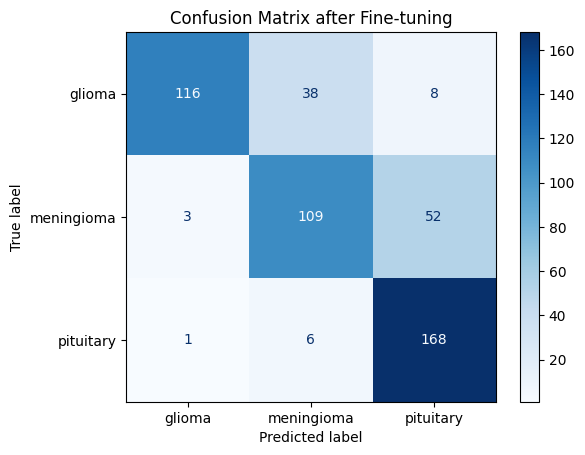

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import cv2
import h5py
import os
import pennylane as qml
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Constants ===
IMG_WIDTH, IMG_HEIGHT = 128, 128
NUM_CLASSES = 3
BATCH_SIZE = 32
EPOCHS_PHASE1 = 50
EPOCHS_PHASE2 = 20
N_QUBITS = 8

# === Load .mat Training Dataset ===
def load_mat_file_v7_3(filepath):
    with h5py.File(filepath, 'r') as file:
        label = int(np.array(file['cjdata']['label']).squeeze())
        image = np.array(file['cjdata']['image']).T
        return label, image

train_mat_path = "/content/dataset/figshare-brain-tumor-dataset/dataset/data"  # update if needed
mat_images, mat_labels = [], []

for filename in os.listdir(train_mat_path):
    if filename.endswith(".mat"):
        path = os.path.join(train_mat_path, filename)
        label, image = load_mat_file_v7_3(path)
        image_resized = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        mat_images.append(image_resized)
        mat_labels.append(label)

mat_images = np.array(mat_images) / 255.0
mat_images = np.expand_dims(mat_images, axis=-1)
X_mat_rgb = np.repeat(mat_images, 3, axis=-1)

encoder = LabelBinarizer()
y_mat_encoded = encoder.fit_transform(mat_labels)

# === Quantum Circuit ===
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def quantum_circuit(inputs):
    for i in range(N_QUBITS):
        qml.RX(inputs[i], wires=i)
        qml.RY(inputs[i], wires=i)
    for i in range(N_QUBITS - 1):
        qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

def quantum_feature_extraction(images):
    quantum_features = []
    for img in images:
        flattened = img.flatten()[:N_QUBITS]
        q_features = quantum_circuit(flattened)
        quantum_features.append(q_features)
    return np.array(quantum_features)

X_mat_q = quantum_feature_extraction(X_mat_rgb)

# === Build Hybrid Model ===
def build_combined_model(fine_tune=False):
    image_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name="Image_Input")
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)

    for layer in base_model.layers:
        layer.trainable = fine_tune

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    vgg_output = Dense(128, activation='relu')(x)

    quantum_input = Input(shape=(N_QUBITS,), name="Quantum_Input")
    q_x = Dense(64, activation='relu')(quantum_input)
    q_output = Dense(32, activation='relu')(q_x)

    combined = Concatenate()([vgg_output, q_output])
    final_x = Dense(128, activation='relu')(combined)
    final_x = Dropout(0.5)(final_x)
    output = Dense(NUM_CLASSES, activation='softmax')(final_x)

    model = Model(inputs=[image_input, quantum_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_combined_model(fine_tune=False)

# === Phase 1: Train on .mat Dataset ===
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

train_inputs = {"Image_Input": X_mat_rgb, "Quantum_Input": X_mat_q}

history = model.fit(
    train_inputs, y_mat_encoded,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_PHASE1,
    callbacks=[reduce_lr],
    verbose=1
)

# Save weights
model.save_weights("vgg16_quantum_phase1.weights.h5")

# === Phase 2: Load and Fine-Tune on Folder Dataset ===
# Folder path format: /content/UnseenData/Glioma, /Meningioma, /Pituitary
folder_dataset_path = "/content/dataset/ValidationDataset"

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

data_gen = datagen.flow_from_directory(
    folder_dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset='training',
    seed=42
)

val_gen = datagen.flow_from_directory(
    folder_dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    subset='validation',
    seed=42
)

# Convert full dataset to NumPy arrays
X_finetune, y_finetune = [], []
for i in range(len(data_gen)):
    x_batch, y_batch = data_gen[i]
    X_finetune.append(x_batch)
    y_finetune.append(y_batch)
    if i >= int(len(data_gen) * 0.1): break

X_finetune = np.concatenate(X_finetune, axis=0)
y_finetune = np.concatenate(y_finetune, axis=0)
X_finetune_q = quantum_feature_extraction(X_finetune)

# === Load model and fine-tune ===
model_finetune = build_combined_model(fine_tune=True)
model_finetune.load_weights("vgg16_quantum_phase1.weights.h5")

finetune_inputs = {"Image_Input": X_finetune, "Quantum_Input": X_finetune_q}

model_finetune.fit(
    finetune_inputs, y_finetune,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_PHASE2,
    callbacks=[reduce_lr],
    verbose=1
)

# === Final Evaluation on Full Unseen Dataset ===
X_eval, y_eval = [], []
for i in range(len(val_gen)):
    x_batch, y_batch = val_gen[i]
    X_eval.append(x_batch)
    y_eval.append(y_batch)

X_eval = np.concatenate(X_eval, axis=0)
y_eval = np.concatenate(y_eval, axis=0)
X_eval_q = quantum_feature_extraction(X_eval)

eval_inputs = {"Image_Input": X_eval, "Quantum_Input": X_eval_q}

loss, accuracy = model_finetune.evaluate(eval_inputs, y_eval)
print(f"\n✅ Final Accuracy on Unseen Dataset: {accuracy:.4f}")

# === Classification Report ===
y_pred = model_finetune.predict(eval_inputs)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_eval, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=val_gen.class_indices.keys()))

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix after Fine-tuning")
plt.show()
